### This notebook focuses on conceptualizing and implementing advanced trading strategies,  building upon the ML models and features developed in the previous notebook.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Suppress specific warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning, module='yfinance')
warnings.filterwarnings('ignore', category=DeprecationWarning)

print("Libraries imported successfully.")

print("Re-downloading NVDA 1 - minute interval data for strategy simulation...")
nvda = yf.Ticker("NVDA")
df = nvda.history(period = "7d", interval = "1m")
df.dropna(inplace = True)

print("Re-applying feature engineering...")

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['rolling_std_20'] = df['Close'].rolling(window=20).std()
df['bollinger_high'] = df['Close'].rolling(window=20).mean() + (df['rolling_std_20'] * 2)
df['bollinger_low'] = df['Close'].rolling(window=20).mean() - (df['rolling_std_20'] * 2)

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
with np.errstate(divide='ignore', invalid='ignore'):
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df['signed_volume'] = df['Volume'] * np.sign(df['log_return'])

for i in [1, 2, 3, 5, 10]:
    df[f'log_return_lag_{i}'] = df['log_return'].shift(i)
    df[f'rsi_lag_{i}'] = df['rsi'].shift(i)

df['hour'] = df.index.hour
df['minute'] = df.index.minute

df.dropna(inplace=True)

# Defining features to use for the ML models
features = [
    'macd', 'macd_signal', 'rolling_std_20', 'rsi', 'signed_volume',
    'log_return_lag_1', 'rsi_lag_1', 'log_return_lag_2', 'rsi_lag_2',
    'log_return_lag_3', 'rsi_lag_3', 'log_return_lag_5', 'rsi_lag_5',
    'log_return_lag_10', 'rsi_lag_10', 'hour', 'minute'
]

# Filtering out features that might not have been created or have all NaNs after dropna
features = [f for f in features if f in df.columns and not df[f].isnull().all()]

# Loading the trained LightGBM model and scaler
model_dir = 'trained_models'
lgbm_model_path = os.path.join(model_dir, 'lgbm_trading_model.pkl')
scaler_path = os.path.join(model_dir, 'scaler.pkl')

if os.path.exists(lgbm_model_path) and os.path.exists(scaler_path):
    with open(lgbm_model_path, 'rb') as f:
        lgbm_model = pickle.load(f)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print("LightGBM model and scaler loaded successfully.")
else:
    print("WARNING: Trained LightGBM model or scaler not found. Please run the 'ML_Model_Implementation.ipynb' notebook first to train and save them.")
    # Fallback: Create dummy model/scaler if not found (for notebook execution without prior run)
    from sklearn.linear_model import LogisticRegression
    lgbm_model = LogisticRegression() # Dummy model
    scaler = StandardScaler() # Dummy scaler
    print("Using dummy model/scaler for demonstration. Results will not be meaningful.")

# Preparing data for prediction using the loaded scaler
X_strategy = df[features]
X_strategy_scaled = scaler.transform(X_strategy)
X_strategy_scaled_df = pd.DataFrame(X_strategy_scaled, columns=features, index=X_strategy.index)

print(f"Data prepared for strategy application. Shape: {X_strategy_scaled_df.shape}")
print(f"Features used: {features}")

Libraries imported successfully.
Re-downloading NVDA 1 - minute interval data for strategy simulation...
Re-applying feature engineering...
LightGBM model and scaler loaded successfully.
Data prepared for strategy application. Shape: (2691, 17)
Features used: ['macd', 'macd_signal', 'rolling_std_20', 'rsi', 'signed_volume', 'log_return_lag_1', 'rsi_lag_1', 'log_return_lag_2', 'rsi_lag_2', 'log_return_lag_3', 'rsi_lag_3', 'log_return_lag_5', 'rsi_lag_5', 'log_return_lag_10', 'rsi_lag_10', 'hour', 'minute']


### Simple ML-Powered Trading Strategy


 Implementing Simple ML-Powered Trading Strategy...
Strategy signals and returns calculated.

First 5 rows with strategy details:
                                Close  log_return  lgbm_prediction  \
Datetime                                                             
2025-07-22 09:54:00-04:00  164.850006   -0.003437                1   
2025-07-22 09:55:00-04:00  165.660004    0.004902                0   
2025-07-22 09:56:00-04:00  165.645004   -0.000091                0   
2025-07-22 09:57:00-04:00  165.139999   -0.003053                1   
2025-07-22 09:58:00-04:00  165.210007    0.000424                1   

                           strategy_signal  strategy_log_return  \
Datetime                                                          
2025-07-22 09:54:00-04:00                1            -0.003437   
2025-07-22 09:55:00-04:00               -1            -0.004902   
2025-07-22 09:56:00-04:00               -1             0.000091   
2025-07-22 09:57:00-04:00                1 

C:\Users\Alqama\AppData\Local\Temp\ipykernel_28960\3146169861.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['cumulative_strategy_returns'].iloc[0] = 1.0 # Start at 1.0 for plotting
C:\Users\Alqama\AppData\Local\Temp\ipykernel_28960

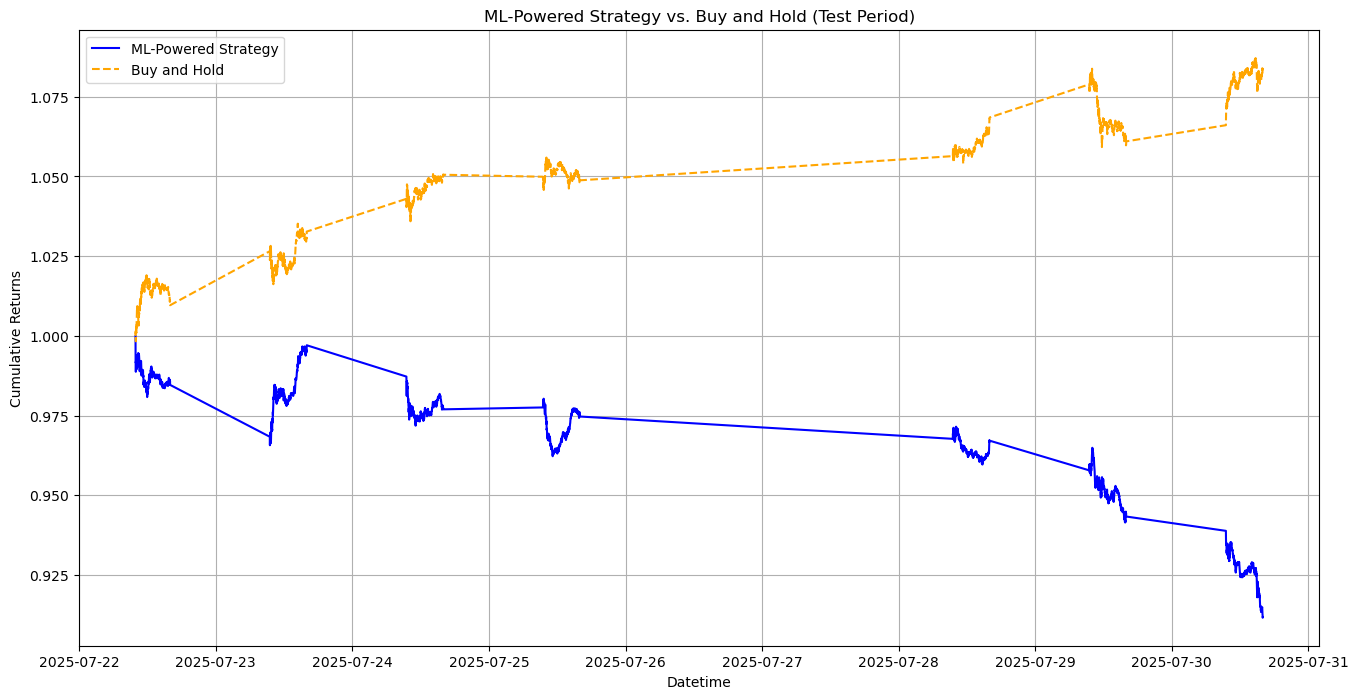

In [36]:
print("\n Implementing Simple ML-Powered Trading Strategy...")

# predictions generation from the loaded LightGBM model
df['lgbm_prediction'] = lgbm_model.predict(X_strategy_scaled_df)
df['lgbm_prediction_proba'] = lgbm_model.predict_proba(X_strategy_scaled_df)[:, 1]

# Defining strategy signals based on predictions
df['strategy_signal'] = df['lgbm_prediction'].apply(lambda x: 1 if x == 1 else -1)

# strategy returns calculation
df['strategy_log_return'] = df['strategy_signal'] * df['log_return']

# cumulative returns calculation
df['cumulative_strategy_returns'] = np.exp(df['strategy_log_return'].cumsum())
df['cumulative_strategy_returns'].iloc[0] = 1.0 # Start at 1.0 for plotting

# buy and hold calculation for comparison
df['cumulative_buy_and_hold'] = np.exp(df['log_return'].cumsum())
df['cumulative_buy_and_hold'].iloc[0] = 1.0

print("Strategy signals and returns calculated.")
print("\nFirst 5 rows with strategy details:")
print(df[['Close', 'log_return', 'lgbm_prediction', 'strategy_signal', 'strategy_log_return', 'cumulative_strategy_returns']].head())

# Strategy Performance Plot
plt.figure(figsize=(16, 8))
plt.plot(df['cumulative_strategy_returns'], label = 'ML-Powered Strategy', color = 'blue')
plt.plot(df['cumulative_buy_and_hold'], label = 'Buy and Hold', color = 'orange', linestyle = '--')
plt.title('ML-Powered Strategy vs. Buy and Hold (Test Period)')
plt.xlabel('Datetime')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

### Conceptualization of Advanced Trading Strategies

In [39]:
print("\n Conceptualizing Advanced Trading Strategies ---")

# 1. Statistical Arbitrage
print("\n1. Statistical Arbitrage (Pairs Trading, Cointegration):")
print("   - DATA REQUIRED: Historical data for multiple related assets.")

# 2. Market-Making Algorithms
print("\n2. Market-Making Algorithms:")
print("   - DATA REQUIRED: Level 2 order book data (bids/asks), micro-price, order flow imbalance.")

# 3. Cross-Asset Strategies
print("\n3. Cross-Asset Strategies:")
print("   - DATA REQUIRED: Historical data for multiple asset classes (equities, bonds, commodities, FX, derivatives).")

# 4. Alternative Data Integration
print("\n4. Alternative Data Integration:")
print("   - DATA REQUIRED: Specific alternative datasets, often requiring significant preprocessing and feature engineering. APIs for news, social media, etc.")


 Conceptualizing Advanced Trading Strategies ---

1. Statistical Arbitrage (Pairs Trading, Cointegration):
   - DATA REQUIRED: Historical data for multiple related assets.

2. Market-Making Algorithms:
   - DATA REQUIRED: Level 2 order book data (bids/asks), micro-price, order flow imbalance.

3. Cross-Asset Strategies:
   - DATA REQUIRED: Historical data for multiple asset classes (equities, bonds, commodities, FX, derivatives).

4. Alternative Data Integration:
   - DATA REQUIRED: Specific alternative datasets, often requiring significant preprocessing and feature engineering. APIs for news, social media, etc.


### Strategy Refinement and Risk Management (Conceptual)
**Beyond just generating signals, a robust trading strategy needs factors:**

In [42]:
# 1. Position Sizing:
print("\n1. Position Sizing:")
print("   - EXAMPLE: If our LGBM model's `lgbm_prediction_proba` is very high (>0.7), we might take a larger position; if it's borderline, a smaller one.")

# 2. Stop-Loss and Take-Profit:
print("\n2. Stop-Loss and Take-Profit:")
print("   - EXAMPLE: Use predicted `rolling_std_20` to set a dynamic stop-loss. If volatility is high, allow for wider price swings.")

# 3. Transaction Costs & Slippage:
print("\n3. Transaction Costs & Slippage:")
print("   - EXAMPLE: Our `TradingEnv` already includes basic transaction costs and slippage. In a real system, these would be calibrated from historical trade data.")

# 4. Market Impact:
print("\n4. Market Impact:")
print("   - EXAMPLE: If our model suggests a very strong buy signal, but the volume is low, an ML-driven execution algorithm might split the order into smaller chunks over time.")


1. Position Sizing:
   - EXAMPLE: If our LGBM model's `lgbm_prediction_proba` is very high (>0.7), we might take a larger position; if it's borderline, a smaller one.

2. Stop-Loss and Take-Profit:
   - EXAMPLE: Use predicted `rolling_std_20` to set a dynamic stop-loss. If volatility is high, allow for wider price swings.

3. Transaction Costs & Slippage:
   - EXAMPLE: Our `TradingEnv` already includes basic transaction costs and slippage. In a real system, these would be calibrated from historical trade data.

4. Market Impact:
   - EXAMPLE: If our model suggests a very strong buy signal, but the volume is low, an ML-driven execution algorithm might split the order into smaller chunks over time.
